# Network Science project

# Twitch Social Network - Germany

Lisanna Lehes, Siim Suitslepp

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import networkx as nx
from networkx.algorithms import community
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
edges = pd.read_csv('musae_DE_edges.csv')
nodes = pd.read_csv('musae_DE_target.csv')

In [3]:
print('Nodes dataset dimension:', nodes.shape, '\nEdges dataset dimension:', edges.shape)

Nodes dataset dimension: (9498, 6) 
Edges dataset dimension: (153138, 2)


## 1. Exploring the data - Descriptive Analysis

In [4]:
nodes.head()

,id,days,mature,views,partner,new_id
0,37905227,2149,True,162078,False,5079
1,63102384,1574,True,1370,False,4281
2,109414094,1034,True,6043,False,992
3,84163849,1319,True,94298,True,9021
4,38240837,2137,True,2323,False,330


In [5]:
edges.head()

,from,to
0,0,9206
1,0,7787
2,0,2145
3,0,2684
4,0,7275


In [6]:
edges.describe()

,from,to
count,153138.000000,153138.000000
mean,3672.458103,6060.992510
std,2511.565127,2437.219301
min,0.000000,5.000000
25%,1613.000000,4150.000000
50%,3173.000000,6619.000000
75%,5519.000000,8080.000000
max,9488.000000,9497.000000


We can see from here that it uses new_id instead of id so we will drop id collumn and only use new_id

### Dropping unnessesary columns

In [7]:
nodes.drop("id", axis=1, inplace=True)

In [8]:
nodes.rename(columns = {'new_id':'id'}, inplace = True)

In [9]:
nodes.head()

,days,mature,views,partner,id
0,2149,True,162078,False,5079
1,1574,True,1370,False,4281
2,1034,True,6043,False,992
3,1319,True,94298,True,9021
4,2137,True,2323,False,330


### Checking for null values

In [10]:
nodes.isnull().sum()

days       0
mature     0
views      0
partner    0
id         0
dtype: int64

In [11]:
edges.isnull().sum()

from    0
to      0
dtype: int64

There are no NAN values in dataset

### Checking data types

In [12]:
nodes.dtypes

days       int64
mature      bool
views      int64
partner     bool
id         int64
dtype: object

In [13]:
#correcting datatypes

nodes.mature = nodes.mature.astype(int) 
nodes.partner = nodes.partner.astype(int)

In [14]:
nodes.dtypes

days       int64
mature     int32
views      int64
partner    int32
id         int64
dtype: object

### Visualizing

Text(0, 0.5, 'Views on Twitch')

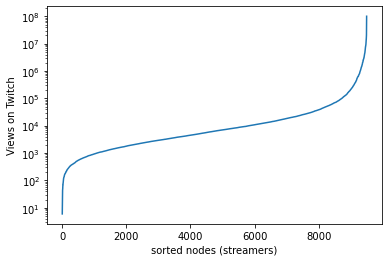

In [15]:
nodes_views = nodes.sort_values(by = ['views'])
views = nodes_views['views']
views = views.reset_index()
plt.plot(views['views'])
plt.yscale("log")
plt.title("")
plt.xlabel("sorted nodes (streamers)")
plt.ylabel("Views on Twitch")

Text(0, 0.5, 'Days on Twitch')

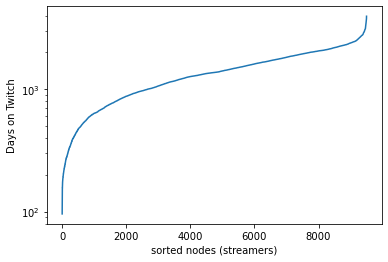

In [16]:
nodes_days = nodes.sort_values(by = ['days'])
days = nodes_days['days']
days = days.reset_index()
plt.plot(days['days'])
plt.yscale("log")
plt.xlabel("sorted nodes (streamers)")
plt.ylabel("Days on Twitch")

In [17]:
nodes.set_index('id')

,days,mature,views,partner
id,,,,
5079,2149,1,162078,0
4281,1574,1,1370,0
992,1034,1,6043,0
9021,1319,1,94298,1
330,2137,1,2323,0
...,...,...,...,...
4572,895,1,128,0
6355,2001,0,44,0
206,1784,1,2038,0


## 2. Graph analysis

In [ ]:
nodes_dict = nodes.to_dict('index')

In [ ]:
# creating the graph

G_unweighted_undirected = nx.from_pandas_edgelist(edges, source='from', target='to')
nx.set_node_attributes(G_unweighted_undirected, nodes_dict)

In [ ]:
# Edge density
nx.classes.function.density(G_unweighted_undirected) 

In [ ]:
# Transitivity
nx.transitivity(G_unweighted_undirected)

In [ ]:
# Average shortest path length
nx.average_shortest_path_length(G_unweighted_undirected) 

In [ ]:
# Clustering coefficient
nx.average_clustering(G_unweighted_undirected) 

In [ ]:
# Diameter of the graph 
#nx.diameter(G_unweighted_undirected) 

In [ ]:
# Betweenness centrality
#nx.betweenness_centrality(G_unweighted_undirected) 

# 3. Attribute analysis 

In [ ]:
# Calculating Correlation

corr = nodes[['days','mature','views','partner']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 30, l=65, center="light", as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
p = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
p.set(title = "Correlation heatmap")

## 4. Model building - classification tasks

## GraphSAGE

GraphSAGE is an inductive framework that leverages node attribute information to efficiently generate representations on previously unseen data. Hence, it is a framework for inductive representation learning on large graphs. It is used to generate low-dimensional vector representations for nodes, and is especially useful for graphs that have rich node attribute information.

In [18]:
!pip install stellargraph
import itertools
import os

from sklearn.manifold import TSNE

import stellargraph as sg
from stellargraph import StellarGraph
from stellargraph import globalvar
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
print("Version:", sg.version.__version__)

Version: 1.2.1


### 1. Data preparation

In [20]:
edges.head()

,from,to
0,0,9206
1,0,7787
2,0,2145
3,0,2684
4,0,7275


In [22]:
nodes.head()

,days,mature,views,partner,id
0,2149,1,162078,0,5079
1,1574,1,1370,0,4281
2,1034,1,6043,0,992
3,1319,1,94298,1,9021
4,2137,1,2323,0,330


In [21]:
# Renaming 'from' and 'to' columns
edges.rename(columns = {'from':'source', 'to':'target'}, inplace = True)
edges.head()

,source,target
0,0,9206
1,0,7787
2,0,2145
3,0,2684
4,0,7275


In [23]:
# Replacing the current index by moving the 'id' column to it
nodes2 = nodes.set_index('id')
nodes2

,days,mature,views,partner
id,,,,
5079,2149,1,162078,0
4281,1574,1,1370,0
992,1034,1,6043,0
9021,1319,1,94298,1
330,2137,1,2323,0
...,...,...,...,...
4572,895,1,128,0
6355,2001,0,44,0
206,1784,1,2038,0


In [24]:
# Dropping the 'label' column
nodes_no_partner = nodes2.drop(columns="partner")
nodes_no_partner

,days,mature,views
id,,,
5079,2149,1,162078
4281,1574,1,1370
992,1034,1,6043
9021,1319,1,94298
330,2137,1,2323
...,...,...,...
4572,895,1,128
6355,2001,0,44
206,1784,1,2038


In order to use methods like GraphSAGE and GCN, which operate on a single graph, we must construct a single instance of the StellarGraph class.  
See [here](https://stellargraph.readthedocs.io/en/latest/demos/basics/loading-pandas.html).

In [25]:
twitch_graph = StellarGraph(nodes_no_partner, edges)
print(twitch_graph.info())

StellarGraph: Undirected multigraph
 Nodes: 9498, Edges: 153138

 Node types:
  default: [9498]
    Features: float32 vector, length 3
    Edge types: default-default->default

 Edge types:
    default-default->default: [153138]
        Weights: all 1 (default)
        Features: none


We’ll  need to use the 'partner' labels as ground-truth labels. This can be extracted from the DataFrame and held separately, to be passed in as training, validation or test examples.

In [26]:
twitch_partner = nodes2["partner"]
twitch_partner

id
5079    0
4281    0
992     0
9021    1
330     0
       ..
4572    0
6355    0
206     0
7695    0
4451    1
Name: partner, Length: 9498, dtype: int32

In [27]:
set(twitch_partner)

{0, 1}

In [28]:
twitch_partner.value_counts()

# Class imbalance could be a problem

0    8901
1     597
Name: partner, dtype: int64

In [29]:
len(twitch_partner)

9498

### 2. Splitting the data

Removing 20% of the nodes from the graph. Then, we are going to train a GraphSAGE model on the reduced graph with the remaining 80% of the nodes from the original graph. Later, we are going to re-introduce the removed nodes and try to predict their labels without re-training the GraphSAGE model.

In [30]:
labels_sampled = twitch_partner.sample(frac=0.8, replace=False, random_state=101)
labels_sampled
print('Length of sampled labels: ', labels_sampled)

Length of sampled labels:  id
5147    0
4829    0
2763    0
8989    0
1381    0
       ..
4756    0
4725    0
9321    0
5662    0
4618    0
Name: partner, Length: 7598, dtype: int32


In [31]:
# Extracting the subgraph corresponding to the sampled nodes
graph_sampled = twitch_graph.subgraph(labels_sampled.index)
print(graph_sampled.info())

StellarGraph: Undirected multigraph
 Nodes: 7598, Edges: 98828

 Node types:
  default: [7598]
    Features: float32 vector, length 3
    Edge types: default-default->default

 Edge types:
    default-default->default: [98828]
        Weights: all 1 (default)
        Features: none


Using scikit-learn to subset the nodes for test and train.

In [170]:
train_labels, test_labels = model_selection.train_test_split(
    labels_sampled,
    train_size=0.05,
    test_size=None,
    stratify=labels_sampled,
    random_state=42,
)
val_labels, test_labels = model_selection.train_test_split(
    test_labels, train_size=0.2, test_size=None, stratify=test_labels, random_state=100,
)

In [171]:
from collections import Counter

Counter(test_labels)

Counter({0: 5431, 1: 345})

In [172]:
train_targets = train_labels
val_targets = val_labels
test_targets = test_labels

### 3. Creating the model in Keras

In [173]:
batch_size = 50
num_samples = [10, 10]

In [174]:
# A GraphSAGENodeGenerator object 
generator = GraphSAGENodeGenerator(graph_sampled, batch_size, num_samples)

Using the generator.flow() method, we can create iterators over nodes that should be used to train, validate, or evaluate the model. For training we use only the training nodes returned from our splitter and the target values. The shuffle=True argument is given to the flow method to improve training.

In [175]:
train_gen = generator.flow(train_labels.index, train_targets, shuffle=True)

Now we can start with our ML model. A few more parameters:

1. The layer_sizes is a list of hidden feature sizes of each layer in the model. We use 32-dimensional hidden node features at each layer

2. The bias and dropout are internal parameters of the model

In [176]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5
)

In [201]:
# Creating a model to predict the 2 categories using Keras sigmoid layers
x_inp, x_out = graphsage_model.in_out_tensors()
prediction = layers.Dense(units=1, activation="sigmoid")(x_out) # units=one for each class

# Sigmoid activation function is used for binary class classification


In [202]:
np.unique(train_targets)

array([0, 1])

In [203]:
train_targets.shape[0] 

379

In [204]:
prediction.shape

TensorShape([None, 1])

### 4. Training and evaluating

Creating the Keras model with the graph inputs x_inp provided by the graph_model and outputs being the predictions from the sigmoid layer

In [205]:
model = Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer = optimizers.Adam(lr=0.005), 
    loss = losses.binary_crossentropy,
    metrics = ["acc"]
)

# For binary classification problems --> binary_crossentropy is usually the choice for loss function
# mean_squared_error may also be used

In [206]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 10, 3)]      0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 100, 3)]     0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, 1, 3)]       0           []                               
                                                                                                  
 reshape_24 (Reshape)           (None, 1, 10, 3)     0           ['input_32[0][0]']               
                                                                                           

Now, training the model and keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set.

In [207]:
# Validation data generator
val_gen = generator.flow(val_labels.index, val_targets)

In [208]:
# Dealing with class imbalance
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced',
                                            classes=np.unique(val_targets),
                                            y=val_targets)
weights = {i:w for i,w in enumerate(weights)}

In [209]:
weights

{0: 0.5316875460574797, 1: 8.38953488372093}

In [210]:
history = model.fit(
    train_gen, epochs=30, validation_data=val_gen, verbose=0, shuffle=False, class_weight=weights
)

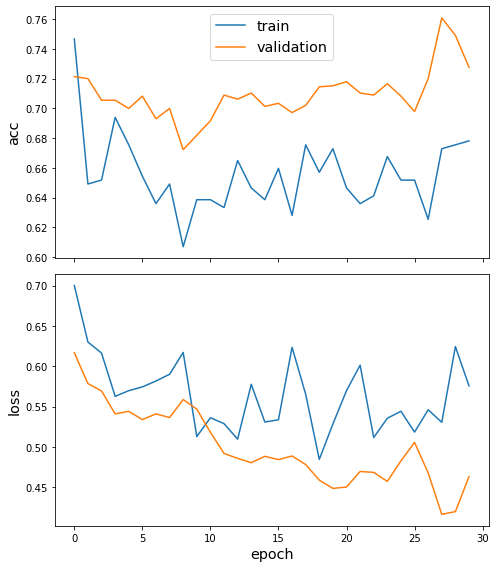

In [211]:
sg.utils.plot_history(history)

In [212]:
# Evaluating on the test set
test_gen = generator.flow(test_labels.index, test_targets)

test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

116/116 [==============================] - 3s 22ms/step - loss: 0.4818 - acc: 0.6948

Test Set Metrics:
	loss: 0.4818
	acc: 0.6948


Adam optimizer is the best choice [in general](https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e). Anyway, many recent papers state that SGD can bring to better results if combined with a good learning rate annealing schedule which aims to manage its value during the training.

In [54]:
graphsage_model2 = GraphSAGE(
    layer_sizes=[32, 32], generator=generator, bias=True, dropout=0.5
)

In [55]:
# Creating a model to predict the 2 categories using Keras sigmoid layers
x_inp2, x_out2 = graphsage_model2.in_out_tensors()
prediction2 = layers.Dense(units=1, activation="sigmoid")(x_out2) 


In [56]:
model2 = Model(inputs=x_inp2, outputs=prediction2)

model2.compile(
    optimizer = optimizers.SGD(lr=0.005), 
    loss = losses.binary_crossentropy,
    metrics = ["acc"]
)

C:\Users\lisannal\Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [57]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 10, 3)]      0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 100, 3)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1, 3)]       0           []                               
                                                                                                  
 reshape_4 (Reshape)            (None, 1, 10, 3)     0           ['input_5[0][0]']                
                                                                                            

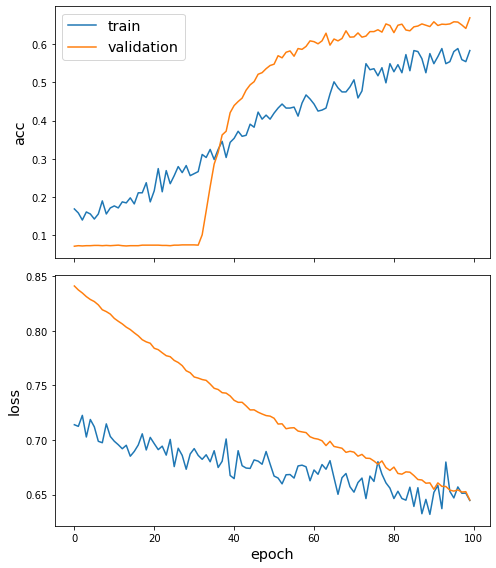

In [60]:
history2 = model2.fit(
    train_gen, epochs=100, validation_data=val_gen, verbose=0, shuffle=False, class_weight=weights
)

sg.utils.plot_history(history2)

In [61]:
# Evaluating on the test set
test_gen = generator.flow(test_labels.index, test_targets)

test_metrics = model2.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model2.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

116/116 [==============================] - 3s 22ms/step - loss: 0.6646 - acc: 0.6202

Test Set Metrics:
	loss: 0.6646
	acc: 0.6202


### 5. Making predictions with the model

Using the trained model to predict the nodes we put aside earlier. For this, we must use the original StellarGraph object and a new node generator.

In [62]:
generator = GraphSAGENodeGenerator(twitch_graph, batch_size, num_samples)

In [63]:
# Predictions for all nodes in the hold out set
hold_out_nodes = twitch_partner.index.difference(labels_sampled.index)
labels_hold_out = twitch_partner[hold_out_nodes]

In [64]:
len(hold_out_nodes)

1900

In [65]:
hold_out_gen = generator.flow(hold_out_nodes, labels_hold_out)

In [66]:
hold_out_predictions = model.predict(hold_out_gen)

In [67]:
len(hold_out_predictions)

1900

In [68]:
# Convert sigmoid predictions to binary labels
new_hold_out_predictions = []

for i, predicted in enumerate(hold_out_predictions):
    if predicted[0] > 0.5: # if probability is >0.5, then it belongs to class 1 (since binary classific.)
        new_hold_out_predictions.append(1)
    else:
        new_hold_out_predictions.append(0)

In [69]:
# Calculate accuracy the "old way"

correct_pred = 0
for i, val in enumerate(new_hold_out_predictions):
    if val == np.array(labels_hold_out)[i]:
        correct_pred += 1
        
correct_pred / len(new_hold_out_predictions)

0.6857894736842105

In [70]:
results = pd.Series(new_hold_out_predictions, index=hold_out_nodes)
df = pd.DataFrame({"Predicted": results, "True": labels_hold_out})
df.head(10)

,Predicted,True
id,,
14,0,0
36,0,0
43,0,0
49,0,0
53,1,0
56,0,0
61,0,0
64,1,0
67,0,0


In [71]:
hold_out_metrics = model.evaluate(hold_out_gen)
print("\nHold Out Set Metrics:")
for name, val in zip(model.metrics_names, hold_out_metrics):
    print("\t{}: {:0.4f}".format(name, val))

38/38 [==============================] - 1s 23ms/step - loss: 0.4370 - acc: 0.6684

Hold Out Set Metrics:
	loss: 0.4370
	acc: 0.6684


## GCN

### 1. Creating layers

In [216]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
#batch_size = 50
#num_samples = [10, 10]

In [217]:
generator_gcn = FullBatchNodeGenerator(graph_sampled, method="gcn")

Using GCN (local pooling) filters...


In [218]:
train_gen = generator_gcn.flow(train_labels.index, train_targets)

In [244]:
gcn = GCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator_gcn, dropout=0.5
)

# voi binary step function?
# relu:https://www.quora.com/Does-it-make-sense-to-use-Relu-activation-on-the-output-neuron-for-binary-classification-If-not-why

In [245]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<KerasTensor: shape=(1, None, 32) dtype=float32 (created by layer 'gather_indices_6')>

In [246]:
predictions = layers.Dense(units=1, activation="sigmoid")(x_out) #sigmoid is used in binary classification

In [247]:
predictions.shape

TensorShape([1, None, 1])

### 2. Training and evaluating the model

In [248]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)


In [249]:
val_gen = generator.flow(val_labels.index, val_targets)
es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [250]:
# Dealing with class imbalance
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced',
                                            classes=np.unique(val_targets),
                                            y=val_targets)
weights = {i:w for i,w in enumerate(weights)}
weights

{0: 0.5316875460574797, 1: 8.38953488372093}

In [251]:
history = model.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
    class_weight=weights
)

Epoch 1/100


InvalidArgumentError: Graph execution error:

indices[0] = 59 is not in [0, 2)
	 [[{{node GatherV2}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_80664]

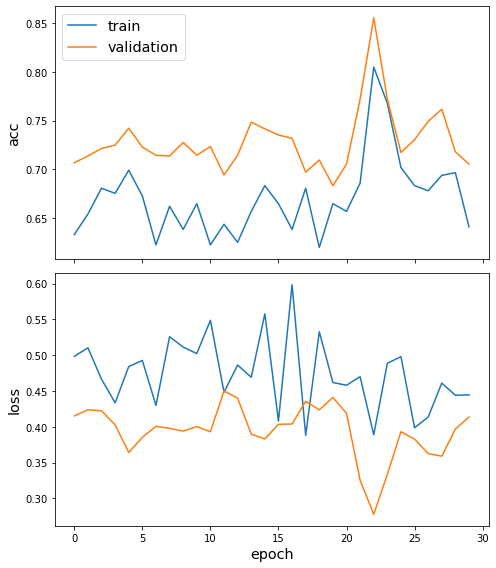

In [82]:
sg.utils.plot_history(history)

In [ ]:
test_gen = generator.flow(test_labels.index, test_targets)

In [ ]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))